# PCFG BIG

As an experiment for the Transformer network, we created an alternate dataset about five times larger than the original. Please run this notebook start to finish to create the corresponding datasets in the `target_dir`.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import os

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
%cd "/content/drive/My Drive/Education/Master Data Science/Master/Semester 1/NLP2/NLP2_2 (shared)"
!ls -lah

/content/drive/My Drive/Education/Master Data Science/Master/Semester 1/NLP2/NLP2_2 (shared)
total 28M
-rw------- 1 root root 140K May 22 15:44  analysis.ipynb
drwx------ 2 root root 4.0K May  6 17:50  code
-rw------- 1 root root 224K May 24 15:12 'Copy of Copy of analysis.ipynb'
-rw------- 1 root root  14M May 24 18:16 'Copy of OpenNMT_Eval.ipynb'
drwx------ 2 root root 4.0K May  3 19:20  data
-rw------- 1 root root  20K May 24 17:41  data_stats.ipynb
drwx------ 2 root root 4.0K May 16 16:07  fairseq
drwx------ 2 root root 4.0K May 13 06:25  logs
drwx------ 2 root root 4.0K May  3 19:20  models
drwx------ 2 root root 4.0K May 22 15:45 'old code (check before removing)'
-rw------- 1 root root  12M May 24 16:17  OpenNMT_Eval.ipynb
drwx------ 2 root root 4.0K May  3 14:41  OpenNMT-py
-rw------- 1 root root  28K May 24 18:16  pcfg_big.ipynb
-rw------- 1 root root  48K May 22 15:05 'pcfg copy.ipynb'
drwx------ 2 root root 4.0K May 12 07:39  poster
-rw------- 1 root root 7.8K May 22 15:44  

In [0]:
target_dir = './data/pcfg_big'

def create_subdirs(target_dir):
  dir_list = [
      "All",
      "Productivity/Tasks/Test1",
      "Productivity/Tasks/Test2",
      "Productivity/Whens/Test3",
      "Productivity/Whens/Test4",
      "Productivity/Whens/Test5",
      "Systematicity/Test1"
  ]
  for d in dir_list:
    os.makedirs(os.path.join(target_dir, d), exist_ok=True)

create_subdirs(target_dir)

In [0]:
# As the original contained 20 entities, 
# this set creates 30 to avoid duplicates 
# and create sufficient unique entities

num_www = 30

WWW = ["who", "what", "where"]

WHO = ["person"+str(i) for i in range(num_www)]
WHAT = ["doing"+str(i) for i in range(num_www)]
WHERE = ["location"+str(i) for i in range(num_www)]

def empty_targets():
  return {"who":[],"what":[],"where":[]}

def get_sentence(lvl=0, targets={}):

  Pwhen = 0.75

  who = np.random.choice(WHO)
  what = np.random.choice(WHAT)
  where = np.random.choice(WHERE)

  parts = [who + " went " + what, "at " + where]

  targets = empty_targets() if lvl==0 else targets
  targets["who"].append(who)
  targets["what"].append(what)
  targets["where"].append(where)

  if np.random.rand() < Pwhen:
    subsentence, targets = get_sentence(lvl=lvl+1, targets=targets)
    parts.append("when " + subsentence)

  np.random.shuffle(parts)
  sentence = " ".join(parts)
  return sentence, targets

In [0]:
def formulate_answer(w1, w2, targets, ask_depth, sentence="", hierarchy="level"):
  q = targets[w2][ask_depth]

  answer = []
  
  #first level first
  if hierarchy == "level":
    #for loop to check for all possible answers
    for i in range(len(targets["who"])):
      if targets[w2][i] == q:
        if w1 == "who" and w2 == "what":
          answer.append(targets[w1][i] + " went " + q)
        elif w1 == "what" and w2 == "who":
          answer.append(q + " went " + targets[w1][i])
        elif w1 == "where" and w2 == "who":
          answer.append(q + " at " + targets[w1][i])
        else: 
          part1 = "at " + targets[w1][i] if w1 == "where" else targets[w1][i]
          part2 = "at " + q if w2 == "where" else q
          answer.append(part1 + " " + part2)

  #first occurence first
  elif hierarchy == "order":
    raise Exception("Working on it!")
  return " ".join(answer) 

def question_props(depth):
  w1, w2 = np.random.choice(WWW, 2, replace=False)
  ask_depth = np.random.randint(depth)
  return w1, w2, ask_depth

def question_answer(sentence, targets, max_tasks=5):
  depth = len(targets["who"])
  num_tasks = np.random.randint(max_tasks)+1
  questions, answers = [], []
  already_asked = []
  for i in range(num_tasks):
    if i == 0:
      w1, w2, ask_depth = question_props(depth)
    else:
      while (w1, w2, ask_depth) in already_asked:
        w1, w2, ask_depth = question_props(depth) 
    already_asked.append((w1, w2, ask_depth))

    question = w1 + " " + targets[w2][ask_depth]
    if question in questions:
      continue 
    answer = formulate_answer(w1, w2, targets, ask_depth)

    questions.append(question)
    answers.append(answer)
  return " ".join(questions), " ".join(answers)

In [0]:
def get_samples(N=10000, max_depth=10, max_tasks=5):
  task_dist = np.zeros(max_tasks)
  samples = set()
  # sample unqique sequences
  while len(samples) < N:
    sentence, targets = get_sentence()


    error = False
    for w in targets["who"]:
      if w not in sentence:
        error = True
    for w in targets["what"]:
      if w not in sentence:
        error = True
    for w in targets["where"]:
      if w not in sentence:
        error = True
    if error:
      print(len(samples))
      print(sentence)
      print(targets)
      raise Exception()
    

    if len(targets["who"]) > max_depth:
      continue
    question, answer = question_answer(sentence, targets, max_tasks=max_tasks)
    model_input = question + " " + sentence
    tasks = num_tasks(model_input)
    task_dist[tasks-1] += 1
    if np.std(task_dist) > 10 or (model_input, answer) in samples:
      task_dist[tasks-1] -= 1
      continue
    samples.add((model_input, answer))
  return samples

def write_data(samples, base_dir=f"{target_dir}", srcfile="source.txt", tgtfile="target.txt"):
  src = open(base_dir + "/" + srcfile, "w")
  tgt = open(base_dir + "/" + tgtfile, "w")
  print(f"Writing {len(samples)} samples.")
  for src_sample, tgt_sample in samples:
    src.write(src_sample+"\n")
    tgt.write(tgt_sample+"\n")

In [0]:
def length_hist(data, include="all", N=1.):
  lengths = []
  for src, tgt in data:
    if include == "all":
      lengths.append(len(src.split()))
    elif include == "tasks":
      lengths.append(num_tasks(src))
    elif include == "sentence":
      lengths.append(len(src.split()) - 2*num_tasks(src))
    elif include == "depth":
      lengths.append(get_depth(src))
    elif include == "target":
      lengths.append(len(tgt.split()))
  counts = Counter(lengths)
  plt.bar(counts.keys(), [freq/N for freq in counts.values()])

def num_tasks(sentence):
  split = sentence.split()
  return split.count("who") + split.count("what") + split.count("where")

def get_depth(sentence):
  return sum(np.array(sentence.split()) == "when")

def get_unique_words(data):
  unique_words = set()
  for src, _ in data:
    unique_words.update(src.split())
  return unique_words

In [0]:
def split_num_tasks(data):
  split = defaultdict(list)
  for src, tgt in data:
    split[num_tasks(src)].append((src, tgt))
  return split

def split_depth(data):
  split = defaultdict(list)
  for src, tgt in data:
    split[get_depth(src)].append((src, tgt))
  return split

def filter_ww(data, ws):
  if not isinstance(ws, list):
    ws = [ws]
  filtered, out = [], []
  for src, tgt in data:
    for w in ws:
      if "who " + w in src or "what " + w in src or "where " + w in src:
        out.append((src, tgt))
        break
    else:
      filtered.append((src, tgt))
  return filtered, out

In [0]:
def save_test_split(data_split, idx, size=2000, name="unknown", base_dir=f"{target_dir}"):
  split = []
  for sample in np.random.permutation(data_split[idx]):
    split.append((sample[0],sample[1])) 
  test_split = split[:size]
  data_split[idx] = split[size:]
  write_data(test_split, base_dir, srcfile=f"prod_test_src_{idx}{name}.txt", 
                                   tgtfile=f"prod_test_tgt_{idx}{name}.txt")
  return test_split, data_split

In [0]:
def check_train_test(train, test):
  train_words = get_unique_words(train)
  test_words = get_unique_words(test)
  for word in test_words:
    if word not in train_words:
      print(f"{word} not in training set! (found in test)")

In [0]:
def remove_tasks(split):
  www = ["who", "what", "where"]
  i = 0
  tasks = []
  while split[i] in www:
    tasks.append([split[i], split[i+1]])
    i += 2
  return np.array(split[i:]), np.array(tasks)
  
def consistent(seq):
  sentence, tasks = remove_tasks(seq.split())
  for q, w in tasks:
    if sum(sentence==w) == 0:
      print(q, w)
      return False
  return True

In [0]:
# As transformers require larger amounts of data
# compared to RNNs, we increase N five fold to
# 200000 samples. This should suffice for most
# tests as a minimal set.

N=200000

for i in range(N):
  while True:
    sentence, targets = get_sentence()
    if len(targets["who"]) > 5:
      continue
    break
  question, answer = question_answer(sentence, targets, max_tasks=5)
  model_input = question + " " + sentence
  if not consistent(model_input):
    print(f"ERROR AT SAMPLE {i}")
    print("sentence: ", sentence)
    print("targets : ", targets)
    print("question: ", question)
    print("answer  : ", answer)
    break

In [0]:
data = get_samples(N=N, max_depth=8, max_tasks=5)
data_list = list(data)

In [72]:
task_split = split_num_tasks(data)
depth_split = split_depth(data)

task1_test, task_split = save_test_split(task_split, 1, size=10000, name="tasks", base_dir=f"{target_dir}/Productivity/Tasks")
task2_test, task_split = save_test_split(task_split, 2, size=10000, name="tasks", base_dir=f"{target_dir}/Productivity/Tasks")
task3_test, task_split = save_test_split(task_split, 3, size=10000, name="tasks", base_dir=f"{target_dir}/Productivity/Tasks")

when0_test, depth_split = save_test_split(depth_split, 0, size=10000, name="whens", base_dir=f"{target_dir}/Productivity/Whens")
when1_test, depth_split = save_test_split(depth_split, 1, size=10000, name="whens", base_dir=f"{target_dir}/Productivity/Whens")
when2_test, depth_split = save_test_split(depth_split, 2, size=10000, name="whens", base_dir=f"{target_dir}/Productivity/Whens")
when3_test, depth_split = save_test_split(depth_split, 3, size=10000, name="whens", base_dir=f"{target_dir}/Productivity/Whens")
when4_test, depth_split = save_test_split(depth_split, 4, size=10000, name="whens", base_dir=f"{target_dir}/Productivity/Whens")

Writing 10000 samples.
Writing 10000 samples.
Writing 10000 samples.
Writing 10000 samples.
Writing 10000 samples.
Writing 10000 samples.
Writing 10000 samples.
Writing 10000 samples.


In [73]:
data_tasks = []
data_whens = []
for key in task_split.keys():
  data_tasks += list(task_split[key])
for key in depth_split.keys():
  data_whens += list(depth_split[key])
len(data_tasks), len(data_whens)

(170000, 150000)

In [0]:
def save_productivity(data, test_idx, filter="tasks", train=[], base_dir=f"{target_dir}/Productivity"):
  if filter == "tasks":
    data_split = split_num_tasks(data)
  elif filter == "whens":
    data_split = split_depth(data)
  train_set = []
  for i in train:
    train_set += data_split[i]
  train_nums = "".join([str(i) for i in train])
  fbegin = f"prod{test_idx}_train_"
  fend = f"_{train_nums}{filter}.txt"
  write_data(train_set, base_dir, srcfile=fbegin + "src" + fend,
                                  tgtfile=fbegin + "tgt" + fend)

In [75]:
#test on number of tasks/questions
save_productivity(data_tasks, 1, filter="tasks", train=[1,2], base_dir=f"{target_dir}/Productivity/Tasks/Test1")
save_productivity(data_tasks, 2, filter="tasks", train=[1,3], base_dir=f"{target_dir}/Productivity/Tasks/Test2")
save_productivity(data_whens, 3, filter="whens", train=[0,1,2], base_dir=f"{target_dir}/Productivity/Whens/Test3")
save_productivity(data_whens, 4, filter="whens", train=[0,1,2,3], base_dir=f"{target_dir}/Productivity/Whens/Test4")
save_productivity(data_whens, 5, filter="whens", train=[0,2,4], base_dir=f"{target_dir}/Productivity/Whens/Test5")

Writing 60017 samples.
Writing 60019 samples.
Writing 98243 samples.
Writing 111909 samples.
Writing 74223 samples.


In [76]:
#test removing person0-2 doing0-2 location0-2 from tasks in training and including in test
filter_out = ["person"+str(i)+" " for i in range(3)]+\
             ["doing"+str(i)+" " for i in range(3)]+\
             ["location"+str(i)+" " for i in range(3)]

syst1_train, syst1_exc_test = filter_ww(data, filter_out)

split = []
for sample in np.random.permutation(syst1_train):
  split.append((sample[0],sample[1]))

syst1_inc_test = split[:20000]
syst1_train = split[20000:]
check_train_test(syst1_train, syst1_inc_test)
check_train_test(syst1_train, syst1_exc_test)

write_data(syst1_train, base_dir=f"{target_dir}/Systematicity/Test1", 
                        srcfile="syst1_train_src_exc012.txt",
                        tgtfile="syst1_train_tgt_exc012.txt")
write_data(syst1_inc_test, base_dir=f"{target_dir}/Systematicity/Test1", 
                           srcfile="syst1_test_src_inc012.txt",
                           tgtfile="syst1_test_tgt_inc012.txt")
write_data(syst1_exc_test, base_dir=f"{target_dir}/Systematicity/Test1", 
                           srcfile="syst1_test_src_exc012.txt",
                           tgtfile="syst1_test_tgt_exc012.txt")

Writing 132965 samples.
Writing 20000 samples.
Writing 47035 samples.


In [77]:
# To keep compatibility with normal models,
# we did not rename the files to their 
# respective sizes.

all_data = []
for sample in np.random.permutation(data_list):
  all_data.append((sample[0],sample[1]))
train, dev, test = all_data[:150000], all_data[150000:175000], all_data[175000:]

write_data(train, base_dir=f"{target_dir}/All", 
                  srcfile="train30k_src_all.txt",
                  tgtfile="train30k_tgt_all.txt")
write_data(dev, base_dir=f"{target_dir}/All", 
                srcfile="dev5k_src_all.txt",
                tgtfile="dev5k_tgt_all.txt")
write_data(test, base_dir=f"{target_dir}/All", 
                 srcfile="test5k_src_all.txt",
                 tgtfile="test5k_tgt_all.txt")

Writing 150000 samples.
Writing 25000 samples.
Writing 25000 samples.


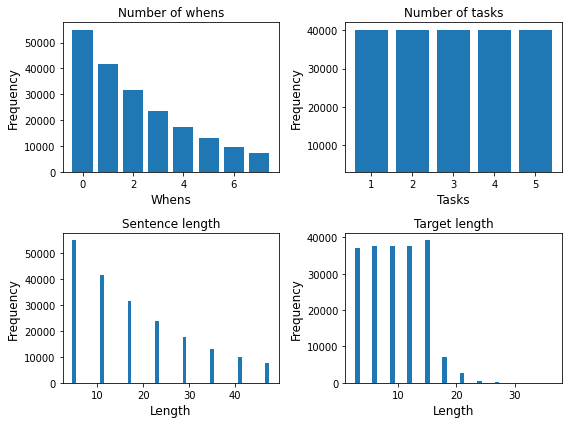

In [78]:
fontsize=12
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.title("Number of whens", fontsize=12)
length_hist(data_list, include="depth")
plt.xlabel("Whens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.subplot(2,2,2)
plt.title("Number of tasks", fontsize=12)
length_hist(data_list, include="tasks")
plt.xlabel("Tasks", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim(3000,None)
plt.subplot(2,2,3)
plt.title("Sentence length", fontsize=12)
length_hist(data_list, include="sentence")
plt.xlabel("Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.subplot(2,2,4)
plt.title("Target length", fontsize=12)
length_hist(data_list, include="target")
plt.xlabel("Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

In [0]:
#check if words in dev and test occur in train
train_words = get_unique_words(train)
dev_words = get_unique_words(dev)
test_words = get_unique_words(test)

for word in dev_words:
  if word not in train_words:
    print(f"{word} not in training set! (found in dev)")

for word in test_words:
  if word not in train_words:
    print(f"{word} not in training set! (found in test)")

In [0]:
# attempt to more natural ordered output
def remove_tasks(split):
  i = 0
  while split[i] in WWW:
    i += 2
  return split[i:]

def get_tasks(split):
  i = 0
  tasks = []
  while split[i] in WWW:
    tasks.append(split[i:i+2])
    i += 2
  return np.array(tasks)

def current_subsent(split, i):
  #only use at start of new subsentence
  www = ['','','']
  while www.count('') > 0:
    w = split[i]
    if w == "when":
      inwhen = 5
      while inwhen:
        i += 1
        inwhen -= 1
        if split[i] == "when":
          inwhen += 6
      w = split[i]
    elif w[:2] == "pe":
      www[0] = w
    elif w[:2] == "do":
      www[1] = w
    elif w[:2] == "lo":
      www[2] = w
    i += 1
  return www

def mask_subsent(split):
  mask = -2*np.ones(len(split))
  mask[np.array(split) == "when"] = -1
  marker = 0
  for i, m in enumerate(mask):
    if m != -1:
      mask[i] = marker
    elif m == -1:
      marker += 1
    while sum(mask==marker) == 5:
      if i < len(split)-1 and split[i+1] == "when":
        break
      else:
        marker -= 1
  return mask

def get_answer(split):
  tasks = get_tasks(split)
  no_tasks = remove_tasks(split)
  mask = mask_subsent(no_tasks)
  parts = ['' for i in range(1+int(np.max(mask)))]
  for i in range(1+int(np.max(mask))):
    parts[i] = current_subsent(no_tasks, int(np.where(mask == i)[0][0]))

In [0]:
# === PCFG ===

# S -> W3 | W4
# W3 -> WHO what where | where WHO what
# W4 -> W3 when | when W3 | WHO what when where | where when WHO what 

# what -> went WHAT
# where -> at WHERE
# when -> "when" S

# WHO -> person0 | person1 | ...
# WHAT -> doing0 | doing1 | ...
# WHERE -> location0 | location1 | ...
